<h1><div align="center">RNN for Timeseries</div></h1>
<div align="center">Bruno Gonçalves</div>
<div align="center"><a href="http://www.bgoncalves.com/">www.bgoncalves.com</a></div>
<div align="center">@bgoncalves</div>
<!--h2 align="center", style="font-size=150%">Part I</h2-->

In [3]:
import numpy as np
np.random.seed(123)

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
tf.set_random_seed(123)

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

from math import sqrt
import matplotlib.pyplot as plt


import watermark

%load_ext watermark
%matplotlib inline

Let's start by print out the versions of the libraries we're using for future reference

In [4]:
%watermark -n -v -m -p numpy,scipy,keras,matplotlib,sklearn,pandas

Tue Sep 11 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
keras 2.2.2
matplotlib 2.2.3
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Load dataset

GDP data from the Federal Reserve Bank [website https://fred.stlouisfed.org/series/GDP](https://fred.stlouisfed.org/series/GDP)

In [15]:
series = pd.read_csv('GDP.csv', header=0, parse_dates=[0], index_col=0)

It's always important to see what you are doing. You can save a lot of time like this ;)

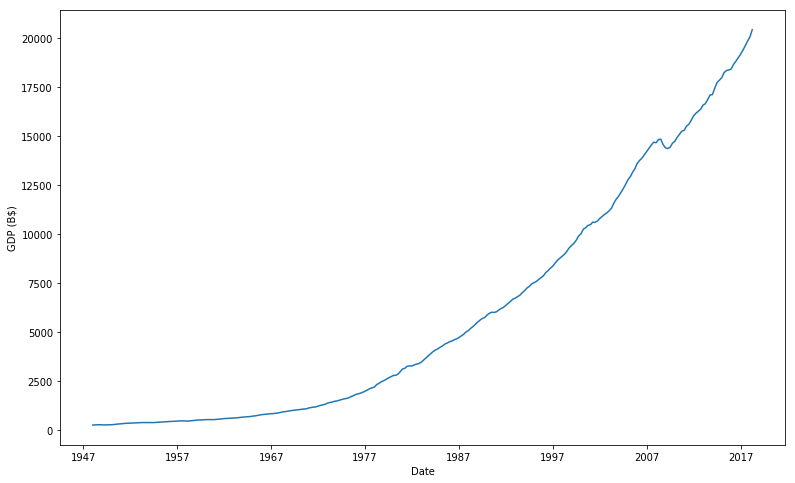

In [16]:
plt.plot(series)
plt.xlabel('Date')
plt.ylabel('GDP (B$)');
plt.gcf().set_size_inches(13,8)

You might remember the little "dip" around 2009.

## Scale the timeseries

The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues.

In [17]:
scaler = MinMaxScaler(feature_range=(-1, 1))
input_data = scaler.fit_transform(series)

#added to see the data a bit
input_data[:10]

array([[-1.        ],
       [-0.99932245],
       [-0.99866436],
       [-0.99854821],
       [-0.99907754],
       [-0.99944317],
       [-0.99929048],
       [-0.99951504],
       [-0.99850234],
       [-0.99755377]])

## Training and Testing datasets 

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it. 

According to the presenter/teacher, this is just a very silly way of doing the testing and training. More realistic: use windowing, look for shorter term predictions

In [19]:
n_points = input_data.shape[0]
train_points = int(2/3*n_points)+1

train, test = input_data[:train_points], input_data[train_points:]

the y values are just the next x value

In [20]:
X_train, X_test = train[:-1], test[:-1]
y_train, y_test = train[1:], test[1:]

print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 188 training points and 92 testing points


The SimpleRNN model expects a 3D dataset so we reshape them accordingly.

In [23]:
tf.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(188, 1, 1)
(92, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

Super easy model definition. Five lines of code

In [26]:
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [28]:
#nb_epoch = 50
nb_epoch = 20
batch_size = 1
verbosity = 1

history = model.fit(X_train, y_train, epochs=nb_epoch, verbose=verbosity, batch_size=batch_size, shuffle=False)

Epoch 1/20
188/188 [==============================] - 0s 1ms/step - loss: 4.4281e-05
Epoch 2/20
188/188 [==============================] - 0s 1ms/step - loss: 4.4692e-05
Epoch 3/20
188/188 [==============================] - 0s 987us/step - loss: 4.5157e-05
Epoch 4/20
188/188 [==============================] - 0s 1ms/step - loss: 4.5633e-05
Epoch 5/20
188/188 [==============================] - 0s 978us/step - loss: 4.6114e-05
Epoch 6/20
188/188 [==============================] - 0s 988us/step - loss: 4.6585e-05
Epoch 7/20
188/188 [==============================] - 0s 984us/step - loss: 4.7000e-05
Epoch 8/20
188/188 [==============================] - 0s 968us/step - loss: 4.7376e-05
Epoch 9/20
188/188 [==============================] - 0s 961us/step - loss: 4.7701e-05
Epoch 10/20
188/188 [==============================] - 0s 1ms/step - loss: 4.7977e-05
Epoch 11/20
188/188 [==============================] - 0s 993us/step - loss: 4.8198e-05
Epoch 12/20
188/188 [============================

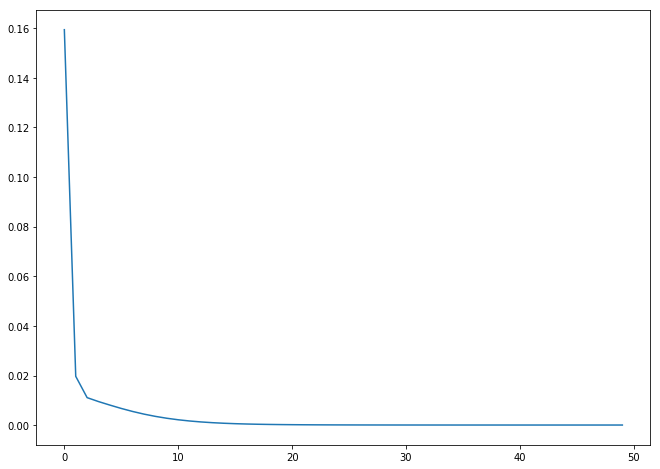

In [11]:
plt.plot(history.epoch, history.history['loss'])
plt.gcf().set_size_inches(11,8)

Make predictions using hte trained model

In [29]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Transform the predictions back to the original units

In [30]:
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

Transform the original data back to the original units

In [31]:
y_train_orig = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

Plot the predicted values. Don't forget to shift the test predictions to the right xx location

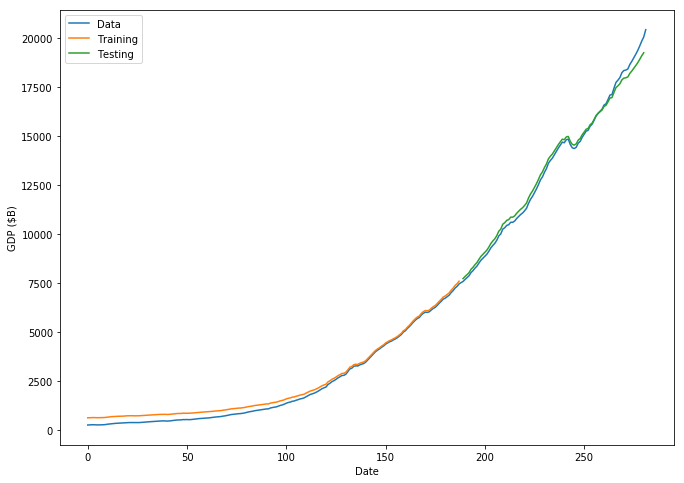

In [32]:
plt.plot(series.values, label='Data')
plt.plot(y_train_pred, label='Training')
plt.plot(len(y_train_pred)+1+np.arange(len(y_test_pred)), y_test_pred, label='Testing')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)

Save the results for later

In [16]:
simple = np.concatenate([y_train_pred, y_test_pred])

# Multiple timesteps

So far we've been using just a SimpleRNN with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

The memory you have, the less training data you'll have

In [35]:
X2_train, X2_test = np.concatenate([train[0:-3], train[1:-2], train[2:-1]], axis=1), np.concatenate([test[0:-3], test[1:-2], test[2:-1]], axis=1)
y2_train, y2_test = train[3:], test[3:]

print("We have", X2_train.shape[0], "training points and", X2_test.shape[0], "testing points")

We have 186 training points and 90 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [36]:
tf.reset_default_graph()
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(186, 3, 1)
(90, 3, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [37]:
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


Train it...

In [41]:
nb_epoch = 100
batch_size = 1

history = model.fit(X2_train, y2_train, epochs=nb_epoch, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/100
 - 0s - loss: 5.7464e-05
Epoch 2/100
 - 0s - loss: 5.7267e-05
Epoch 3/100
 - 0s - loss: 5.6890e-05
Epoch 4/100
 - 0s - loss: 5.6643e-05
Epoch 5/100
 - 0s - loss: 5.6371e-05
Epoch 6/100
 - 0s - loss: 5.6091e-05
Epoch 7/100
 - 0s - loss: 5.5886e-05
Epoch 8/100
 - 0s - loss: 5.5637e-05
Epoch 9/100
 - 0s - loss: 5.5444e-05
Epoch 10/100
 - 0s - loss: 5.5167e-05
Epoch 11/100
 - 0s - loss: 5.5080e-05
Epoch 12/100
 - 0s - loss: 5.4794e-05
Epoch 13/100
 - 0s - loss: 5.4634e-05
Epoch 14/100
 - 0s - loss: 5.4413e-05
Epoch 15/100
 - 0s - loss: 5.4238e-05
Epoch 16/100
 - 0s - loss: 5.4036e-05
Epoch 17/100
 - 0s - loss: 5.3873e-05
Epoch 18/100
 - 0s - loss: 5.3683e-05
Epoch 19/100
 - 0s - loss: 5.3520e-05
Epoch 20/100
 - 0s - loss: 5.3347e-05
Epoch 21/100
 - 0s - loss: 5.3184e-05
Epoch 22/100
 - 0s - loss: 5.2979e-05
Epoch 23/100
 - 0s - loss: 5.2913e-05
Epoch 24/100
 - 0s - loss: 5.2694e-05
Epoch 25/100
 - 0s - loss: 5.2582e-05
Epoch 26/100
 - 0s - loss: 5.2441e-05
Epoch 27/100
 - 0s - 

And take a look at the results

NameError: name 'simple' is not defined

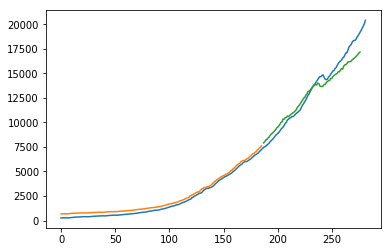

In [40]:
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

y2_train_pred = scaler.inverse_transform(y2_train_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)

y2_train_orig = scaler.inverse_transform(y2_train.reshape(-1,1))
y2_test_orig = scaler.inverse_transform(y2_test.reshape(-1,1))

plt.plot(series.values, label='Data')
plt.plot(y2_train_pred, label='Training')
plt.plot(len(y2_train_pred)+1+np.arange(len(y2_test_pred)), y2_test_pred, label='Testing')
plt.plot(simple, label='Simple')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)

We've also included the previous result for ease of reference. Surprisingly, this new result is actually a bit worse. This is likely due to 

In [22]:
multiple = np.concatenate([y2_train_pred, y2_test_pred])

# LSTM

Let's see how an LSTM would behave in this situation. Now we have the advantage that everything else remains the same, and only the network architecture changes (slightly)

In [46]:
tf.reset_default_graph()
keras.backend.clear_session()

model = Sequential()
model.add(LSTM(units=4, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Naturally, we have many more parameters to train

In [47]:
nb_epoch = 50
batch_size = 1

history = model.fit(X2_train, y2_train, epochs=nb_epoch, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/50
 - 1s - loss: 0.7726
Epoch 2/50
 - 1s - loss: 0.1982
Epoch 3/50
 - 1s - loss: 0.0544
Epoch 4/50
 - 1s - loss: 0.0354
Epoch 5/50
 - 1s - loss: 0.0300
Epoch 6/50
 - 1s - loss: 0.0250
Epoch 7/50
 - 1s - loss: 0.0202
Epoch 8/50
 - 1s - loss: 0.0158
Epoch 9/50
 - 1s - loss: 0.0120
Epoch 10/50
 - 1s - loss: 0.0088
Epoch 11/50
 - 1s - loss: 0.0063
Epoch 12/50
 - 1s - loss: 0.0043
Epoch 13/50
 - 1s - loss: 0.0029
Epoch 14/50
 - 1s - loss: 0.0019
Epoch 15/50
 - 1s - loss: 0.0012
Epoch 16/50
 - 1s - loss: 7.3899e-04
Epoch 17/50
 - 1s - loss: 4.3890e-04
Epoch 18/50
 - 1s - loss: 2.5854e-04
Epoch 19/50
 - 1s - loss: 1.5087e-04
Epoch 20/50
 - 1s - loss: 9.1080e-05
Epoch 21/50
 - 1s - loss: 6.1491e-05
Epoch 22/50
 - 1s - loss: 5.0067e-05
Epoch 23/50
 - 1s - loss: 4.8634e-05
Epoch 24/50
 - 1s - loss: 5.1749e-05
Epoch 25/50
 - 1s - loss: 5.5969e-05
Epoch 26/50
 - 1s - loss: 5.9367e-05
Epoch 27/50
 - 1s - loss: 6.1013e-05
Epoch 28/50
 - 1s - loss: 6.0739e-05
Epoch 29/50
 - 1s - loss: 5.8788e

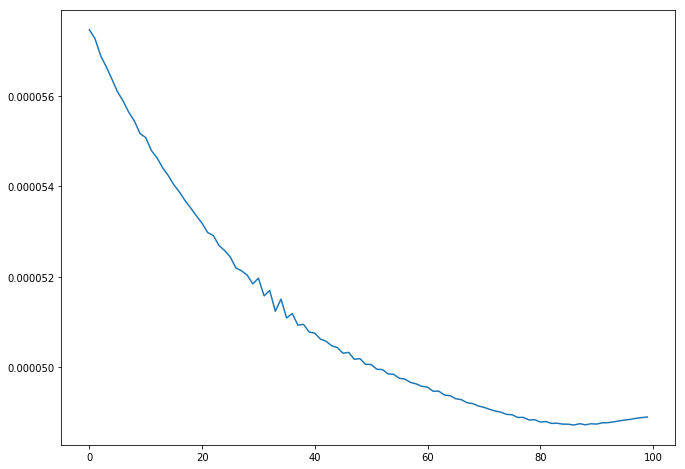

In [42]:
plt.plot(history.epoch, history.history['loss'])
plt.gcf().set_size_inches(11,8)

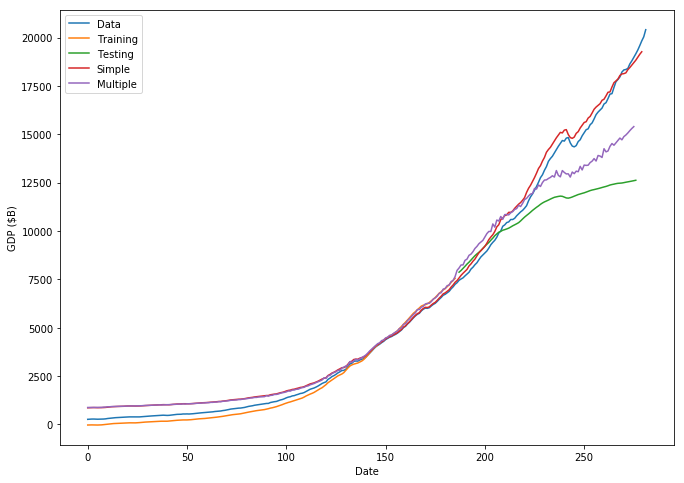

In [26]:
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

y2_train_pred = scaler.inverse_transform(y2_train_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)

y2_train_orig = scaler.inverse_transform(y2_train.reshape(-1,1))
y2_test_orig = scaler.inverse_transform(y2_test.reshape(-1,1))

plt.plot(series.values, label='Data')
plt.plot(y2_train_pred, label='Training')
plt.plot(len(y2_train_pred)+1+np.arange(len(y2_test_pred)), y2_test_pred, label='Testing')
plt.plot(simple, label='Simple')
plt.plot(multiple, label='Multiple')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)

lstm = np.concatenate([y2_train_pred, y2_test_pred])

## Stacked LSTM

In [48]:
tf.reset_default_graph()
keras.backend.clear_session()

model = Sequential()
model.add(LSTM(units=4, batch_input_shape=(1, X2_train.shape[1], X2_train.shape[2]), return_sequences=True))
model.add(LSTM(units=4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 3, 4)                 96        
_________________________________________________________________
lstm_2 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [49]:
nb_epoch = 50
batch_size = 1

history = model.fit(X2_train, y2_train, epochs=nb_epoch, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/50
 - 2s - loss: 0.3047
Epoch 2/50
 - 1s - loss: 0.0215
Epoch 3/50
 - 1s - loss: 0.0197
Epoch 4/50
 - 1s - loss: 0.0176
Epoch 5/50
 - 1s - loss: 0.0154
Epoch 6/50
 - 1s - loss: 0.0134
Epoch 7/50
 - 1s - loss: 0.0115
Epoch 8/50
 - 1s - loss: 0.0097
Epoch 9/50
 - 1s - loss: 0.0081
Epoch 10/50
 - 1s - loss: 0.0066
Epoch 11/50
 - 1s - loss: 0.0052
Epoch 12/50
 - 1s - loss: 0.0041
Epoch 13/50
 - 1s - loss: 0.0031
Epoch 14/50
 - 1s - loss: 0.0023
Epoch 15/50
 - 1s - loss: 0.0017
Epoch 16/50
 - 1s - loss: 0.0012
Epoch 17/50
 - 1s - loss: 8.3526e-04
Epoch 18/50
 - 1s - loss: 5.6713e-04
Epoch 19/50
 - 1s - loss: 3.7648e-04
Epoch 20/50
 - 1s - loss: 2.4489e-04
Epoch 21/50
 - 1s - loss: 1.5672e-04
Epoch 22/50
 - 1s - loss: 9.9501e-05
Epoch 23/50
 - 1s - loss: 6.3752e-05
Epoch 24/50
 - 1s - loss: 4.2523e-05
Epoch 25/50
 - 1s - loss: 3.0867e-05
Epoch 26/50
 - 1s - loss: 2.5435e-05
Epoch 27/50
 - 1s - loss: 2.4083e-05
Epoch 28/50
 - 1s - loss: 2.5451e-05
Epoch 29/50
 - 1s - loss: 2.8557e-05


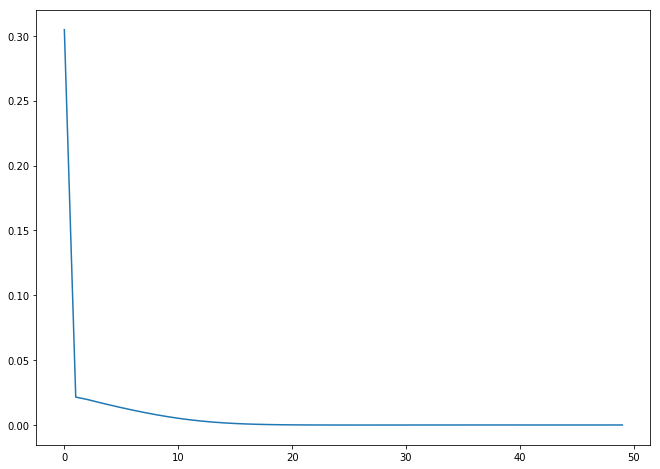

In [51]:
plt.plot(history.epoch, history.history['loss'])
plt.gcf().set_size_inches(11,8)

NameError: name 'simple' is not defined

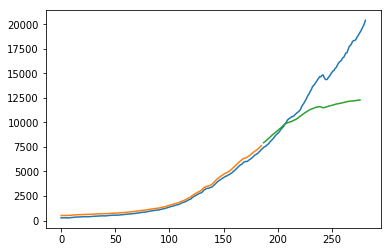

In [53]:
y2_train_pred = model.predict(X2_train, batch_size=1)
y2_test_pred = model.predict(X2_test, batch_size=1)

y2_train_pred = scaler.inverse_transform(y2_train_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)

y2_train_orig = scaler.inverse_transform(y2_train.reshape(-1,1))
y2_test_orig = scaler.inverse_transform(y2_test.reshape(-1,1))

plt.plot(series.values, label='Data')
plt.plot(y2_train_pred, label='Training')
plt.plot(len(y2_train_pred)+1+np.arange(len(y2_test_pred)), y2_test_pred, label='Testing')
plt.plot(simple, label='Simple')
plt.plot(multiple, label='Multiple')
plt.plot(lstm, label='LSTM')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)

stacked = np.concatenate([y2_train_pred, y2_test_pred])

# GRU

In [54]:
tf.reset_default_graph()
keras.backend.clear_session()

model = Sequential()
model.add(GRU(units=4, batch_input_shape=(1, X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, 4)                    72        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [55]:
nb_epoch = 50
batch_size = 1

history = model.fit(X2_train, y2_train, epochs=nb_epoch, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/50
 - 1s - loss: 1.0421
Epoch 2/50
 - 0s - loss: 0.1578
Epoch 3/50
 - 0s - loss: 0.0345
Epoch 4/50
 - 0s - loss: 0.0285
Epoch 5/50
 - 0s - loss: 0.0250
Epoch 6/50
 - 0s - loss: 0.0216
Epoch 7/50
 - 0s - loss: 0.0183
Epoch 8/50
 - 0s - loss: 0.0153
Epoch 9/50
 - 0s - loss: 0.0126
Epoch 10/50
 - 0s - loss: 0.0102
Epoch 11/50
 - 0s - loss: 0.0081
Epoch 12/50
 - 0s - loss: 0.0063
Epoch 13/50
 - 0s - loss: 0.0048
Epoch 14/50
 - 0s - loss: 0.0036
Epoch 15/50
 - 0s - loss: 0.0026
Epoch 16/50
 - 0s - loss: 0.0018
Epoch 17/50
 - 0s - loss: 0.0013
Epoch 18/50
 - 0s - loss: 8.5063e-04
Epoch 19/50
 - 0s - loss: 5.6323e-04
Epoch 20/50
 - 0s - loss: 3.6714e-04
Epoch 21/50
 - 0s - loss: 2.3711e-04
Epoch 22/50
 - 0s - loss: 1.5303e-04
Epoch 23/50
 - 0s - loss: 9.9885e-05
Epoch 24/50
 - 0s - loss: 6.6974e-05
Epoch 25/50
 - 0s - loss: 4.6993e-05
Epoch 26/50
 - 0s - loss: 3.5130e-05
Epoch 27/50
 - 0s - loss: 2.8318e-05
Epoch 28/50
 - 0s - loss: 2.4656e-05
Epoch 29/50
 - 0s - loss: 2.2969e-05
Epoc

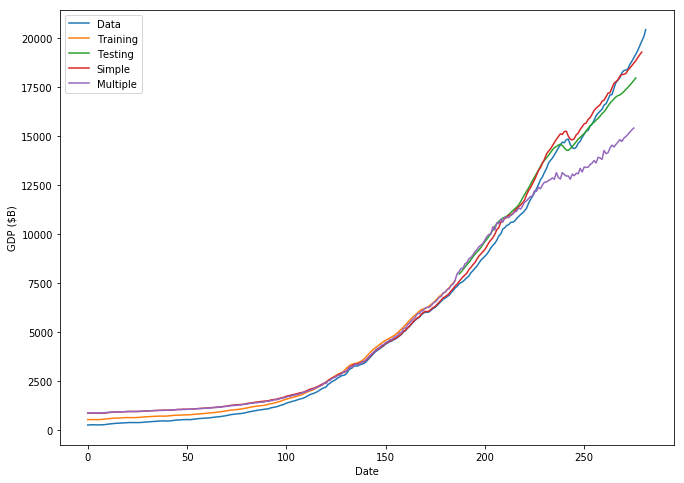

In [33]:
y2_train_pred = model.predict(X2_train, batch_size=1)
y2_test_pred = model.predict(X2_test, batch_size=1)

y2_train_pred = scaler.inverse_transform(y2_train_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)

y2_train_orig = scaler.inverse_transform(y2_train.reshape(-1,1))
y2_test_orig = scaler.inverse_transform(y2_test.reshape(-1,1))

plt.plot(series.values, label='Data')
plt.plot(y2_train_pred, label='Training')
plt.plot(len(y2_train_pred)+1+np.arange(len(y2_test_pred)), y2_test_pred, label='Testing')
plt.plot(simple, label='Simple')
plt.plot(multiple, label='Multiple')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)